# Ski Bearing Playground

- https://geoffboeing.com/2018/07/comparing-city-street-orientations/
- https://doi.org/10.1007/s41109-019-0189-1
- https://github.com/gboeing/osmnx
- https://github.com/russellporter/openskimap.org/issues/82
- groomed v ungroomed
- https://github.com/tilezen/joerd
- trail orientation v aspect
- weight by elevation descent
- max slope v difficulty by region
- https://osmnx.readthedocs.io/en/stable/internals-reference.html-osmnx-bearing-module
- https://stackoverflow.com/questions/54873868/python-calculate-bearing-between-two-lat-long
- https://github.com/gboeing/osmnx/blob/cabdbb246dc14095f5d8e8b8ead38f9649dae2c7/osmnx/bearing.py#L18


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import plotly.express as px
import polars as pl

import ski_bearings.analyze
import ski_bearings.plot
import ski_bearings.utils

In [3]:
ski_areas_pl = pl.read_parquet("data/ski_area_metrics.parquet")
bearing_dists_pl = pl.read_parquet("data/bearing_distributions.parquet")

In [4]:
%config InlineBackend.figure_formats = ['svg']

In [5]:
new_england_ski_area_df = (
    ski_areas_pl.join(bearing_dists_pl, on="ski_area_id", how="inner")
    .filter(pl.col("status") == "operating")
    .filter(pl.col("ski_area_name").is_not_null())
    .filter(pl.col("location__localized__en__country") == "United States")
    # .filter(pl.col("location__localized__en__region").is_in(["Vermont"]))
    .filter(
        pl.col("location__localized__en__region").is_in(
            ["New Hampshire", "Vermont", "Maine", "Massachusetts"]
        )
    )
    .filter(pl.col("run_count_filtered") > 0)
    .filter(num_bins=32)
    .filter(pl.col("run_count_filtered") > 10)
)

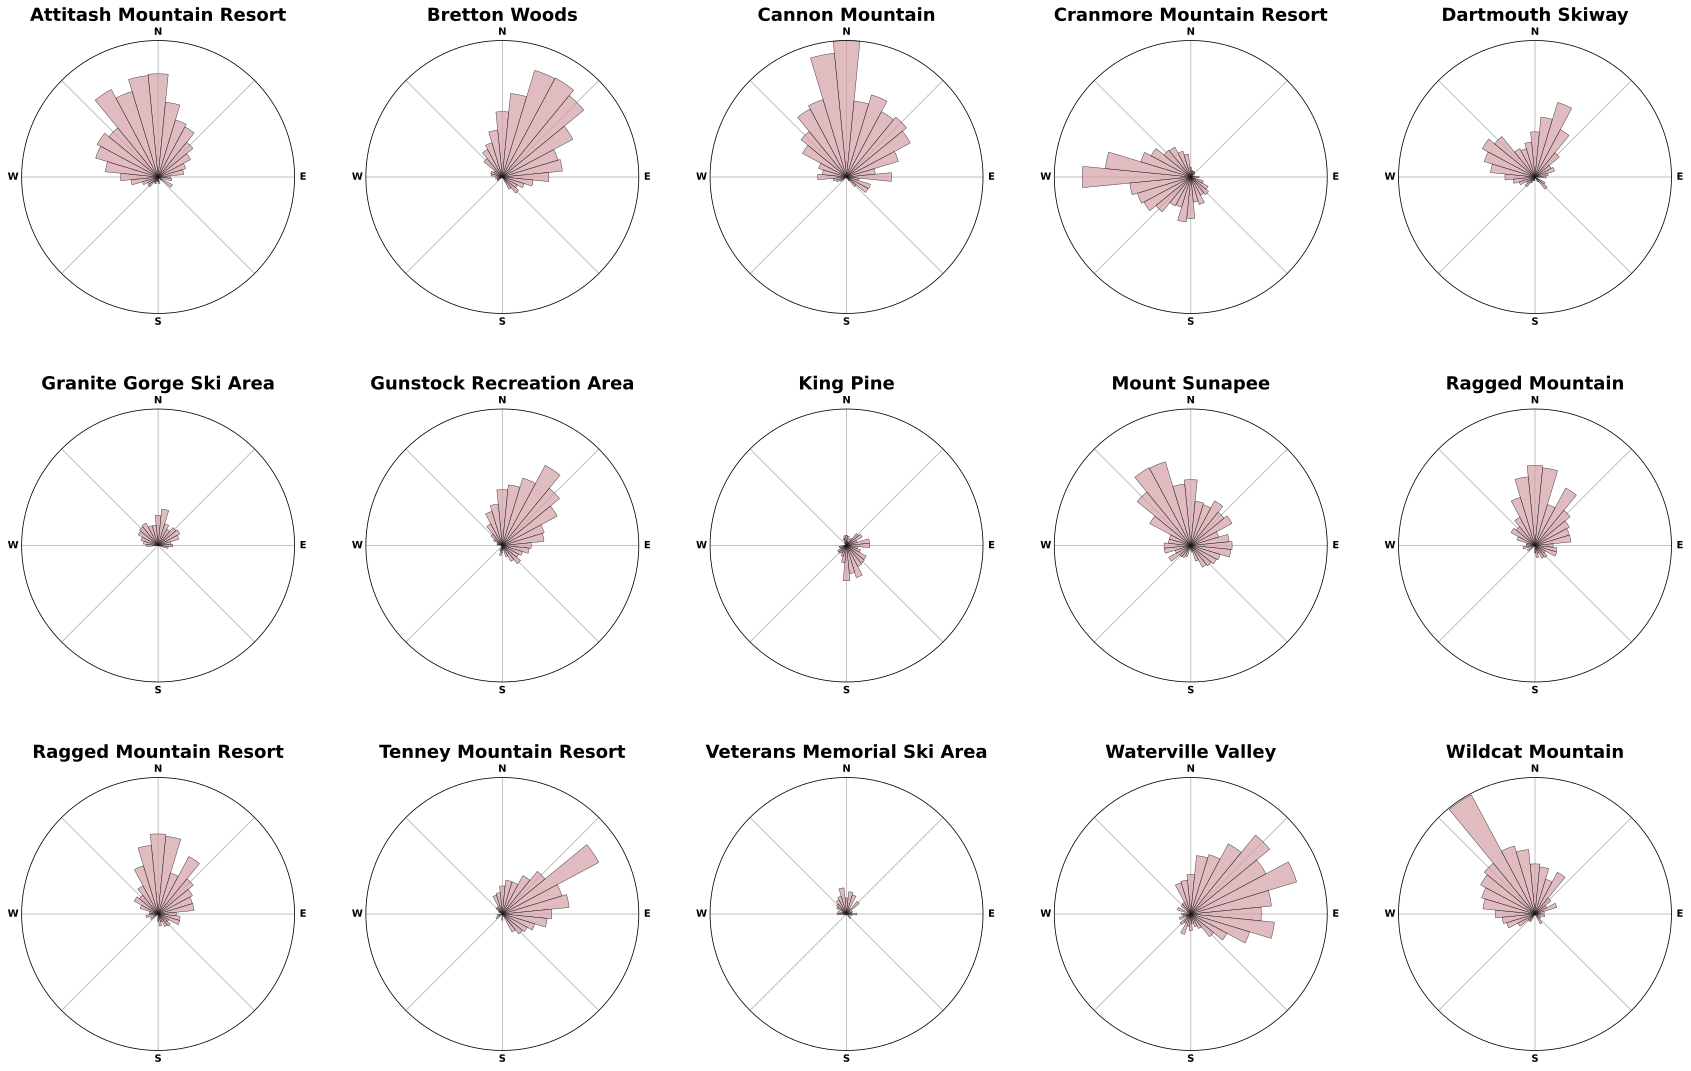

In [11]:
ski_bearings.plot.subplot_orientations(
    distribution_pl=new_england_ski_area_df.filter(
        pl.col("location__localized__en__region") == "New Hampshire"
    ),
    grouping_col="ski_area_name",
    n_cols=5,
    free_y=False,
)

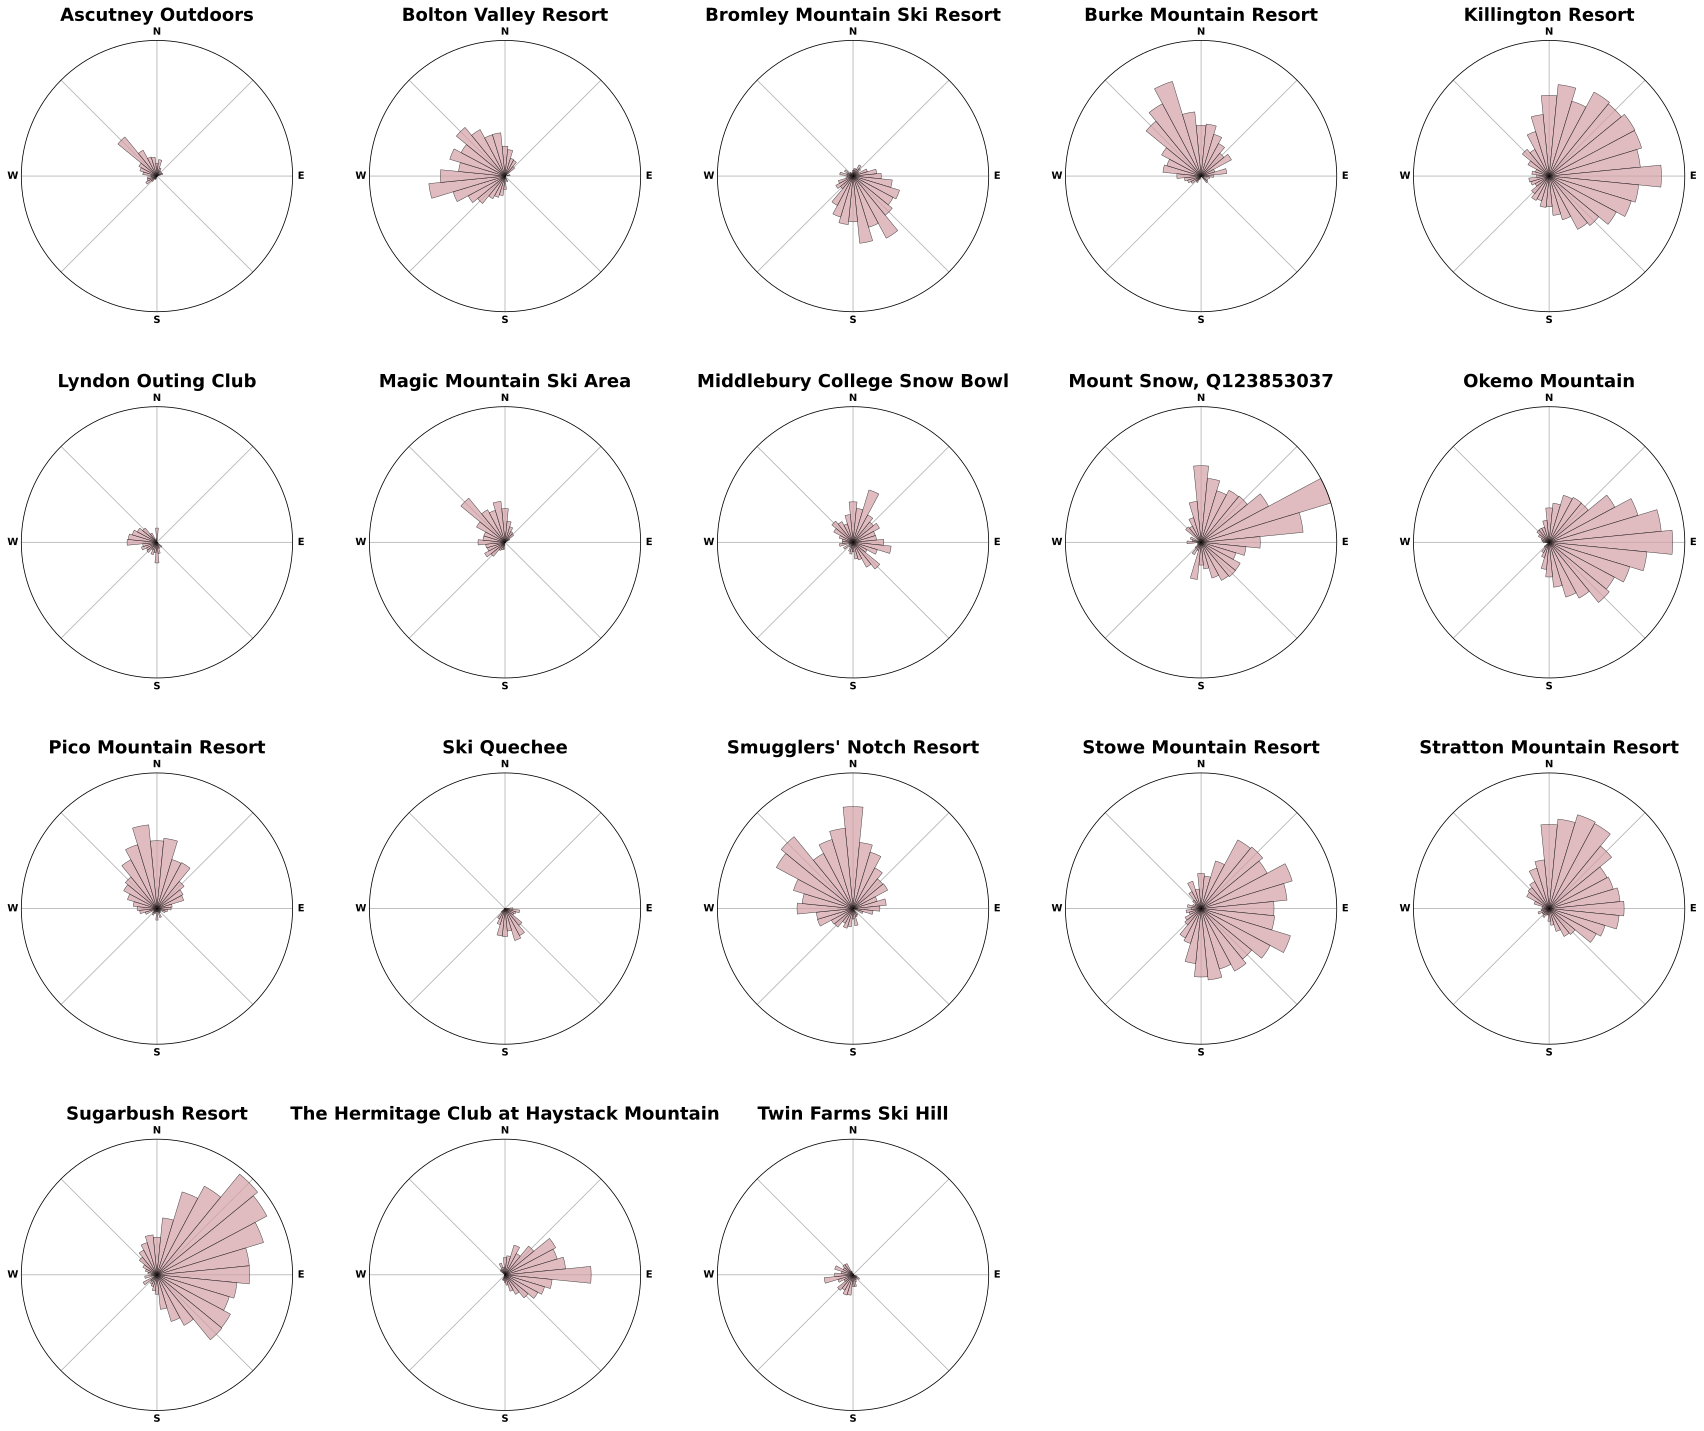

In [12]:
ski_bearings.plot.subplot_orientations(
    distribution_pl=new_england_ski_area_df.filter(
        pl.col("location__localized__en__region") == "Vermont"
    ),
    grouping_col="ski_area_name",
    n_cols=5,
    free_y=False,
)

In [8]:
px.scatter_polar(
    data_frame=new_england_ski_area_df.rename(
        {"location__localized__en__region": "state"}
    ),
    r="mean_bearing_strength",
    theta="mean_bearing",
    size="combined_vertical",
    hover_name="ski_area_name",
    hover_data=["run_count_filtered", "run_count"],
    color="state",
    range_r=[0, 1],
    width=800,
    height=800,
)

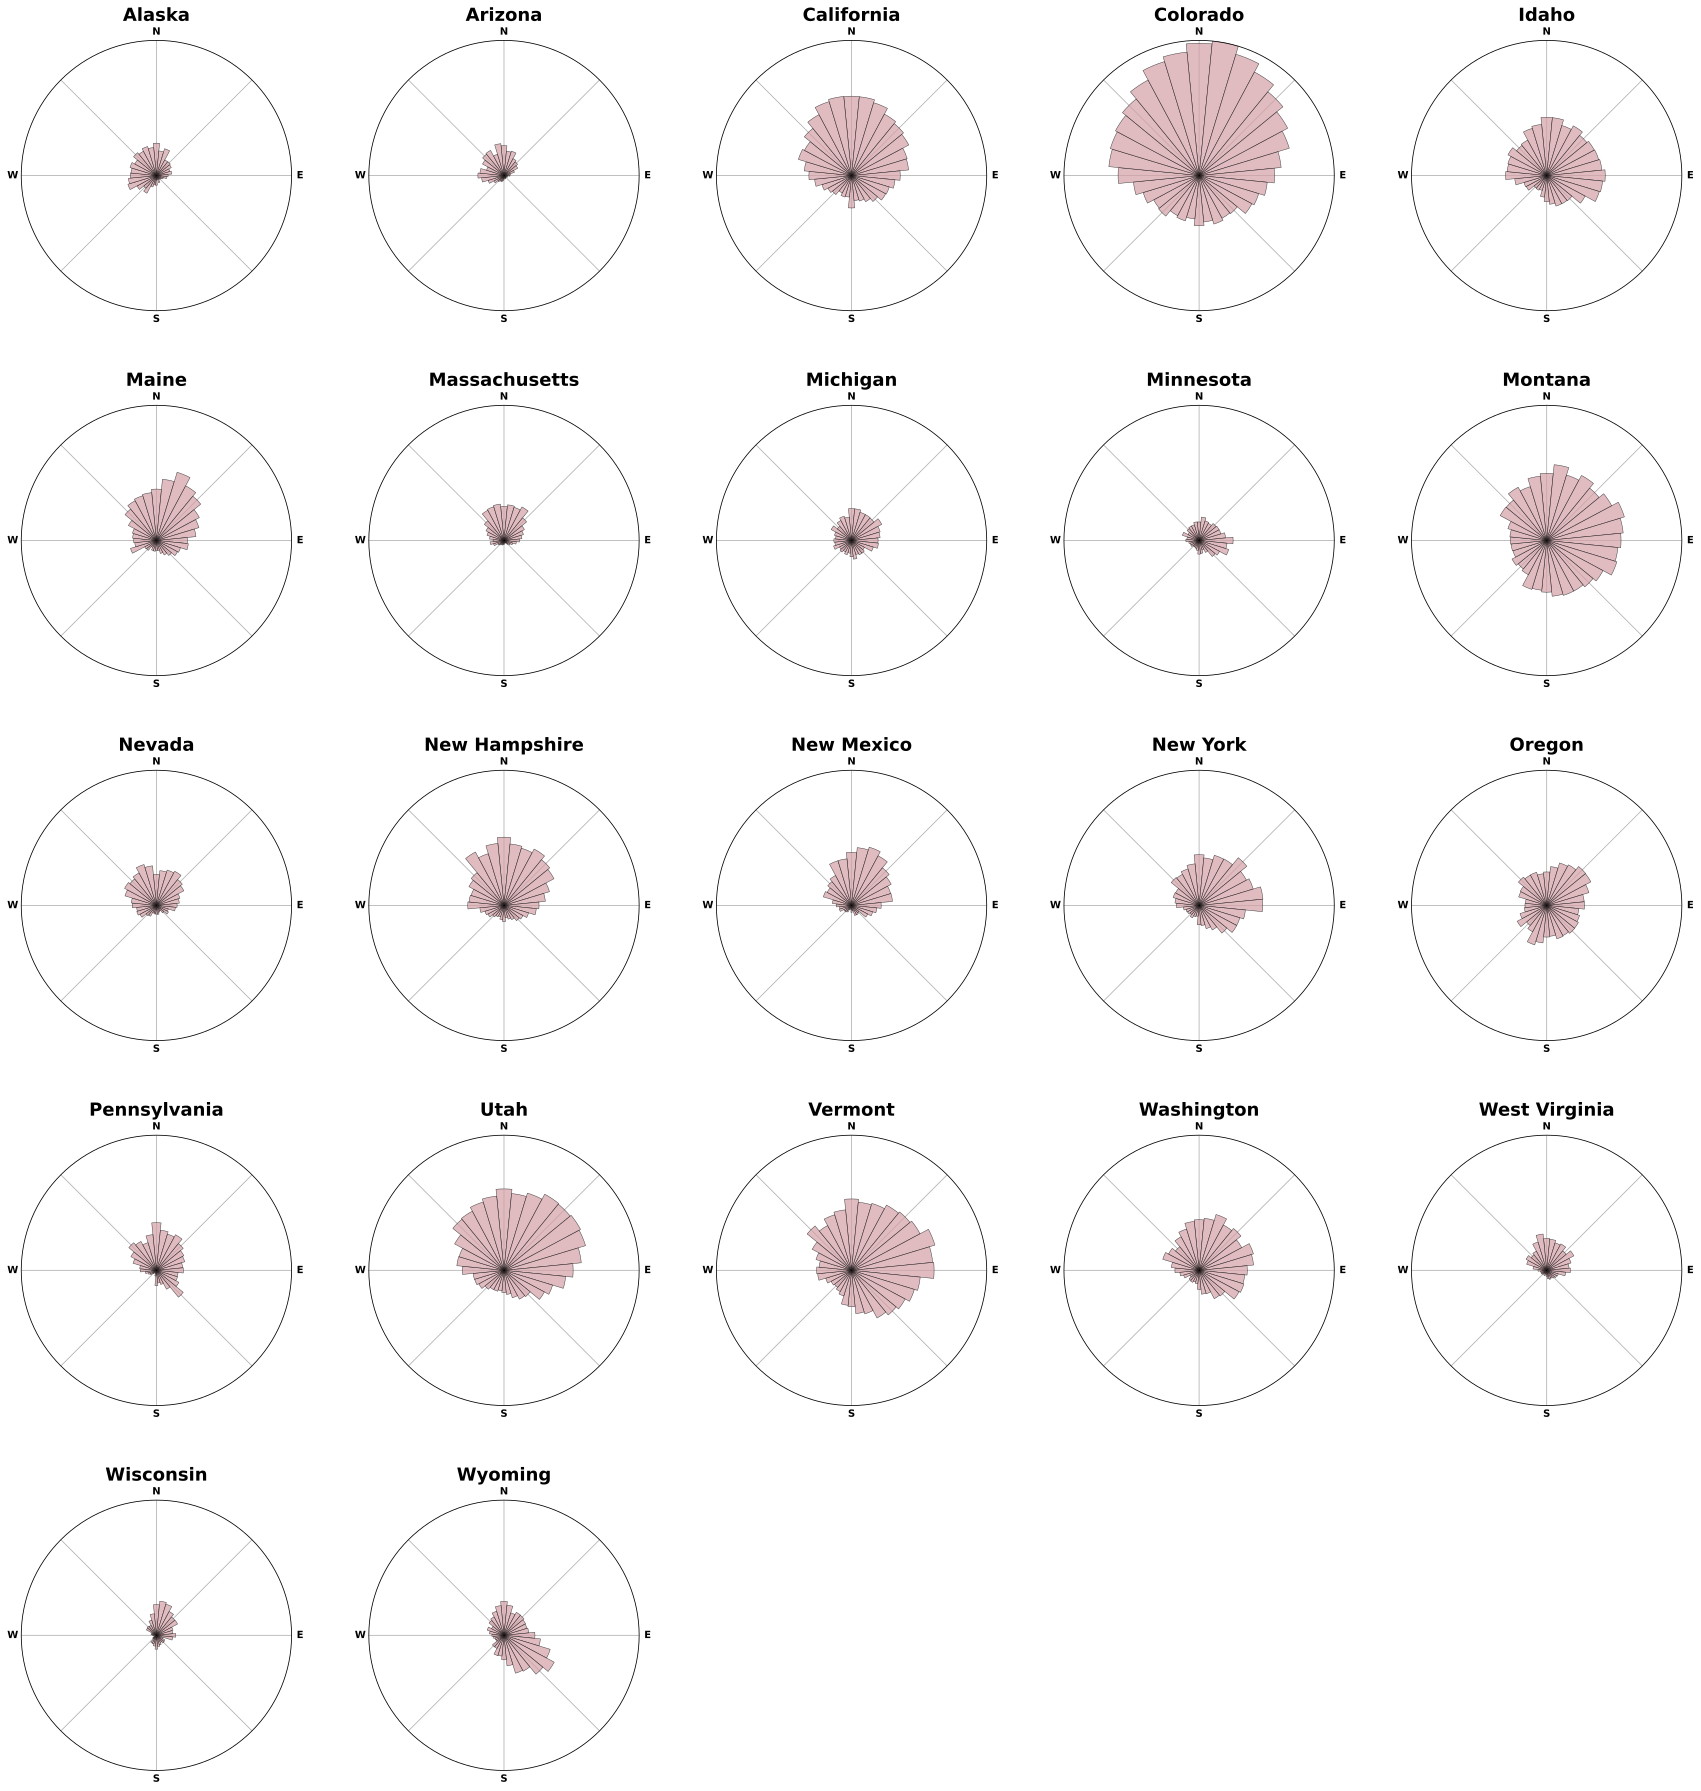

In [13]:
us_state_dists_pl = (
    ski_bearings.analyze.bearing_dists_by_us_state()
    .filter(num_bins=32)
    .filter(pl.col("bin_count_total") > 10_000)
)
ski_bearings.plot.subplot_orientations(
    distribution_pl=us_state_dists_pl,
    grouping_col="location__localized__en__region",
    n_cols=5,
    free_y=False,
)

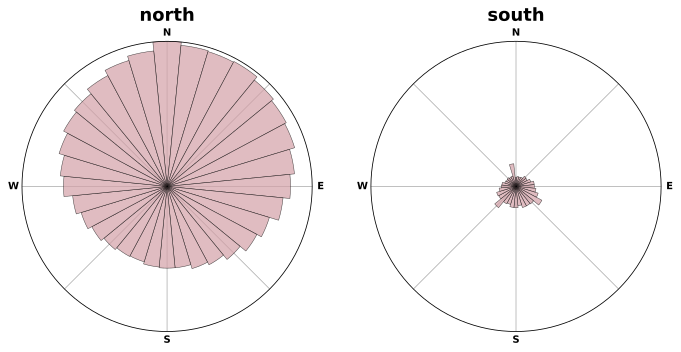

In [14]:
hemisphere_dists_pl = ski_bearings.analyze.bearing_dists_by_hemisphere().filter(
    num_bins=32
)
ski_bearings.plot.subplot_orientations(
    distribution_pl=hemisphere_dists_pl,
    grouping_col="hemisphere",
    n_cols=2,
    free_y=False,
)

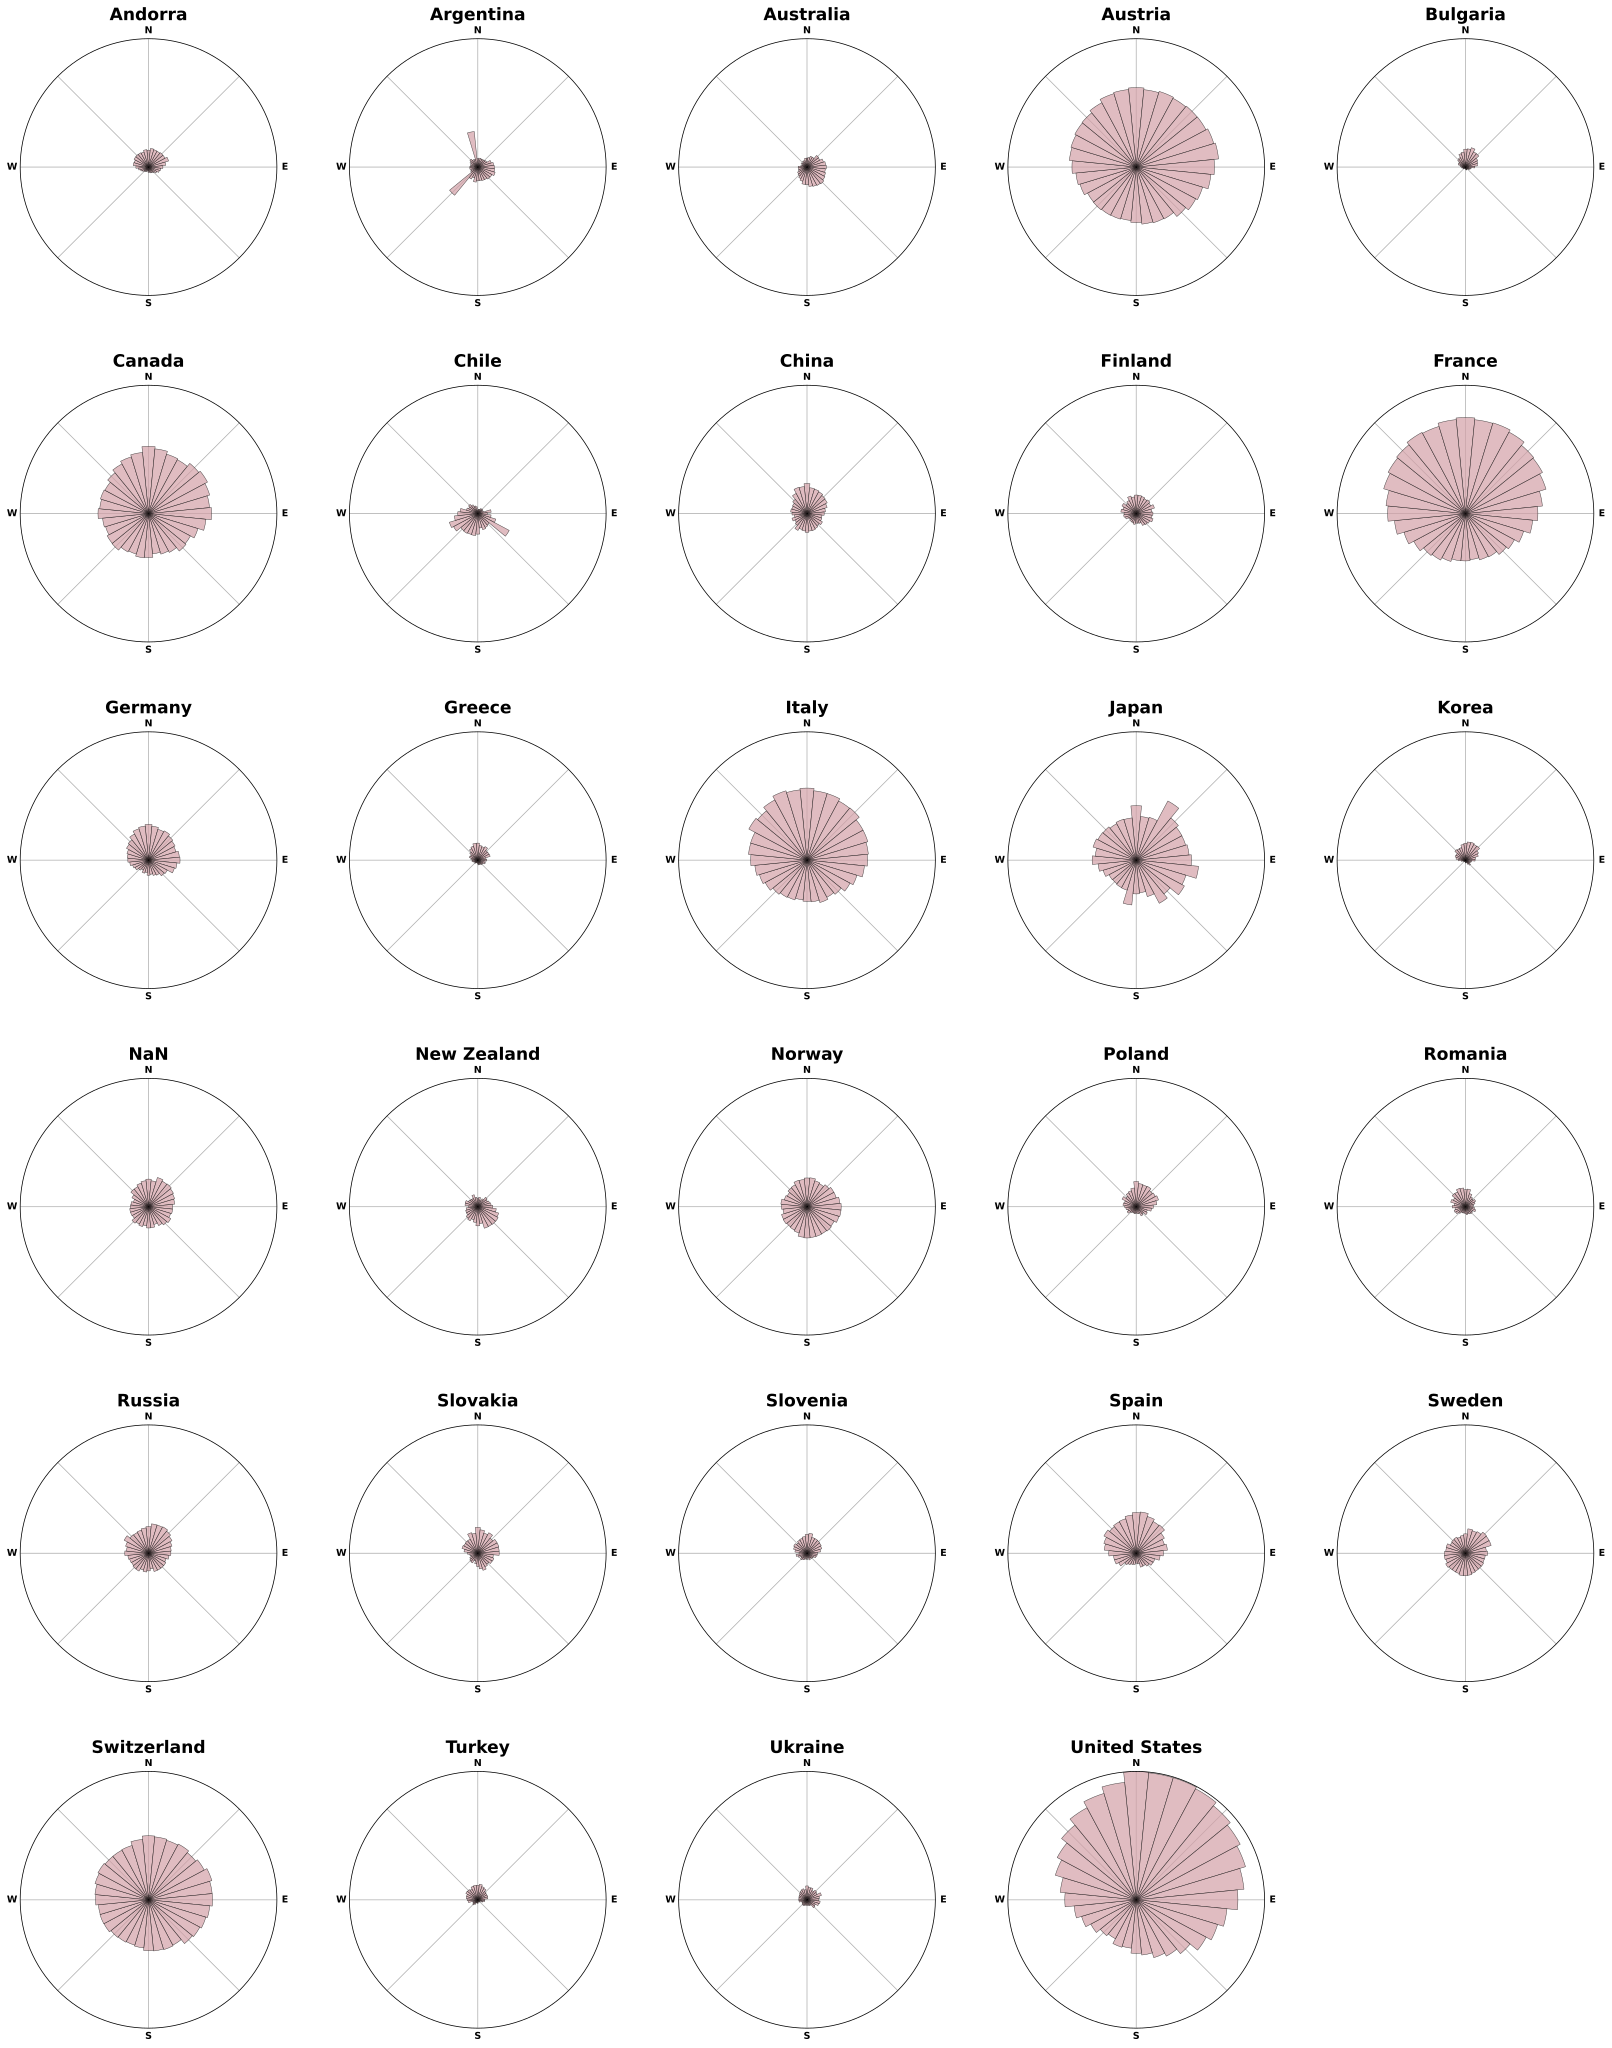

In [15]:
(
    ski_bearings.analyze.bearing_dists_by_country()
    .filter(num_bins=32)
    .filter(pl.col("bin_count_total") > 20_000)
    .pipe(
        function=ski_bearings.plot.subplot_orientations,
        grouping_col="location__localized__en__country",
        n_cols=5,
        free_y=False,
    )
)

In [11]:
ski_bearings.analyze.bearing_dists_by_hemisphere().filter(num_bins=2)

hemisphere,num_bins,bin_center,bin_label,bin_count,bin_count_total,bin_proportion
str,i32,f64,str,f64,f64,f64
"""north""",2,0.0,"""N""",5.7985e6,8.6966e6,0.66675
"""north""",2,180.0,"""S""",2.8981e6,8.6966e6,0.33325
"""south""",2,0.0,"""N""",62287.44,221549.7,0.281144
"""south""",2,180.0,"""S""",159262.26,221549.7,0.718856


In [12]:
ski_areas_pl.get_column("status").value_counts()

status,count
str,u32
"""abandoned""",855
null,202
"""operating""",5352
"""proposed""",39


In [13]:
ski_areas_pl.get_column("runConvention").value_counts()

runConvention,count
str,u32
"""europe""",3978
"""japan""",699
"""north_america""",1771
